In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
# configurações globais
sns.set_theme()                                                   # gráfico
plt.rcParams['figure.figsize'] = [20, 12]                         # gráfico
# pd.set_option('display.float_format', lambda x: '%.5f' % x)       # notação científica

In [45]:
def get_data(path):
    data = pd.read_csv(path)
    return data

def clean_data(data):
    '''
   a Foram identificados alguns imóveis duplicados. 
    Tais imóveis foram colocados a venda em uma determinada data e depois colocados a venda em outra data com um preço maior. 
    Nesse caso, desconsideraremos a primeira aprição desse imóveis no dataset.
    Também desconsideraremos um dos imóveis que possui um número muito alto de quartos com relação ao seu tamanho.
    '''
    df = data[data.duplicated('id')]
    data = data.drop_duplicates('id', keep='last', ignore_index=True)
    
    # para excluir a linha cujo imóvel possui 33 quartos:
    a = data.index[data['bedrooms'] == 33].tolist()
    data = data.drop(a[0]).reset_index()
    data = data.drop(columns='index')
    data.to_csv('datasets/kc_house_data_clean.csv', index=False)
    
    return data

def waterfront_insight(data):
    
    data['price_sqft'] = data['price']/data['sqft_lot']
    df = data[['waterfront', 'price_sqft']].groupby('waterfront').mean().reset_index()
    
    ratio = (df['price_sqft'][1]/df['price_sqft'][0] - 1)*100
     
    print('H1: Imóveis com vista para a água possuem o preço por pé quadrado construído 30% superior, na média.')
    print(f'Hipótese verdadeira. O preço do pé quadrado das casas que possuem vista para água é {round(ratio, 2)}%, na média, maior.')
    print('')

    return None

def yr_built_insight(data):
    df = data[['yr_built', 'price']].groupby('yr_built').mean().reset_index()
    
    a = data.loc[(data['yr_built'] < 1975), 'price'].mean()
    b = data.loc[data['yr_built'] >= 1975, 'price'].mean()
    ratio1 = (b/a - 1)*100
    
    a = data.loc[(data['yr_built'] < 1975) & (data['yr_renovated'] < 1975), 'price'].mean()
    b = data.loc[(data['yr_built'] >= 1975) | (data['yr_renovated'] >= 1975), 'price'].mean()
    ratio2 = (b/a - 1)*100
    
    print('H2: Imóveis com data de construção maior que 1975 são 20% mais caros, na média.')
    print(f'Hipótese falsa, o preço é, na média, {round(ratio1, 2)}% superior.', end='') 
    print(f'Porém é importante notar que se considerarmos os imóveis que foram reformados depois de 1975,', end='')
    print(f'a diferença passa para {round(ratio2, 2)}%')
    print('')
    
    return None

def yr_renovated_insight(data):
    # imóveis que foram reformados por região
    df1 = data[data['yr_renovated'] != 0][['zipcode', 'price']].groupby('zipcode').mean().reset_index() 
    # imóveis que não foram reformados por região
    df2 = data[data['yr_renovated'] == 0][['zipcode', 'price']].groupby('zipcode').mean().reset_index() 
    
    df = df1.merge(df2, on='zipcode')
    df.columns = ['zipcode', 'price_renovated', 'price_not_renovated']
    
    df['ratio'] = df['price_renovated']/df['price_not_renovated']
    ratio = (df['ratio'].mean() - 1)*100
    ratio_max = (df['ratio'].max() - 1)*100
            
    print('H3: Por região, imóveis que sofreram reforma possuem, na média,', end='') 
    print('o preço 30% superior com relação aos que não foram reformados.')
    print(f'Hipótese falsa. Na média, os preços dos imóveis, por região, que foram reformados são {round(ratio, 2)}%', end='')
    print(f' maiores do que os que não foram. Porém, em algumas regiões esse percentual pode chegar a {round(ratio_max, 2)}%.')
    print('')
    
    return None

def seasonality_insight(data):
    data['month'] = pd.to_datetime(data['date']).dt.month
    
    data.loc[(data['month'] >= 6) & (data['month'] <= 8), 'temporal'] = 'Summer'
    data.loc[(data['month'] >= 7) & (data['month'] <= 11), 'temporal'] = 'Autumn'
    data.loc[(data['month'] == 12) | (data['month'] == 1) | (data['month'] == 2), 'temporal'] = 'Winter'
    data.loc[(data['month'] >= 3) & (data['month'] <= 5), 'temporal'] = 'Spring'
    
    price_summer = data.loc[(data['temporal'] == 'Summer'), 'price'].mean()    
    price_winter = data.loc[(data['temporal'] == 'Winter'), 'price'].mean()
    
    ratio1 = (price_summer/price_winter - 1)*100
    
    df_summer = data[(data['temporal'] == 'Summer') | 
                     (data['temporal'] == 'Spring')][['zipcode', 'price']].groupby('zipcode').mean().reset_index()
    df_winter = data[(data['temporal'] == 'Winter') | 
                     (data['temporal'] == 'Autumn')][['zipcode', 'price']].groupby('zipcode').mean().reset_index()
    
    df = df_summer.merge(df_winter, on='zipcode')
    df.columns = ['zipcode', 'mean_price_summer', 'mean_price_winter']
    df['ratio'] = df['mean_price_summer']/df['mean_price_winter']
    ratio2 = (df['ratio'].max() - 1)*100
    
    print('H4: Os valores dos imóveis com data no verão são na média 20% superior do que os com data no inverno.')
    print(f'Hipótese falsa. O preço dos imóveis anunciados no verão são {round(ratio1, 2)}% superior quando comparados', end='') 
    print(f' com os anunciados no inverno. Porém, em algumas localidades, essa porcentagem pode subir para {round(ratio2, 2)}%.')
    
    return None

data = get_data('datasets/kc_house_data.csv')

clean_data(data)

waterfront_insight(data)

yr_built_insight(data)

yr_renovated_insight(data)

seasonality_insight(data)

H1: Imóveis com vista para a água possuem o preço por pé quadrado construído 30% superior, na média.
Hipótese verdadeira. O preço do pé quadrado das casas que possuem vista para água é 37.5%, na média, maior.

H2: Imóveis com data de construção maior que 1975 são 20% mais caros, na média.
Hipótese falsa, o preço é, na média, 13.41% superior.Porém é importante notar que se considerarmos os imóveis que foram reformados depois de 1975,a diferença passa para 20.99%

H3: Por região, imóveis que sofreram reforma possuem, na média,o preço 30% superior com relação aos que não foram reformados.
Hipótese falsa. Na média, os preços dos imóveis, por região, que foram reformados são 17.49% maiores do que os que não foram. Porém, em algumas regiões esse percentual pode chegar a 135.28%.

H4: Os valores dos imóveis com data no verão são na média 20% superior do que os com data no inverno.
Hipótese falsa. O preço dos imóveis anunciados no verão são 7.47% superior quando comparados com os anunciados no

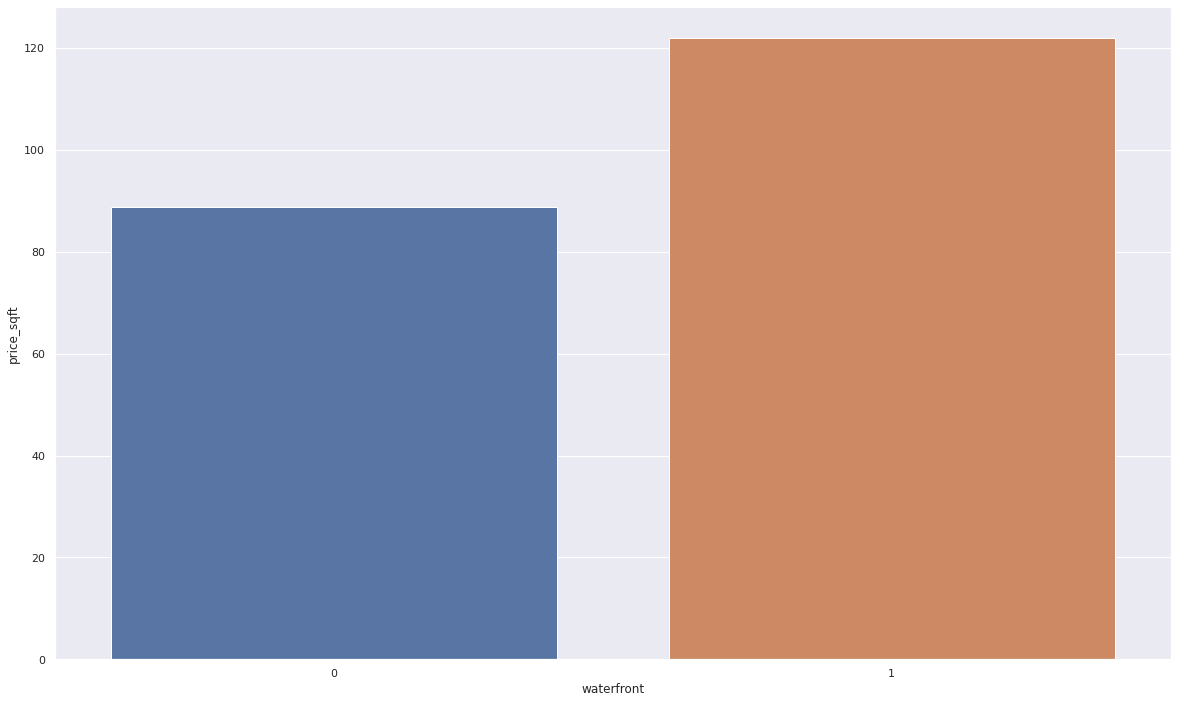

In [46]:
# waterfront insight
data['price_sqft'] = data['price']/data['sqft_lot']
df = data[['waterfront', 'price_sqft']].groupby('waterfront').mean().reset_index()
sns.barplot(data=df, x='waterfront', y='price_sqft');

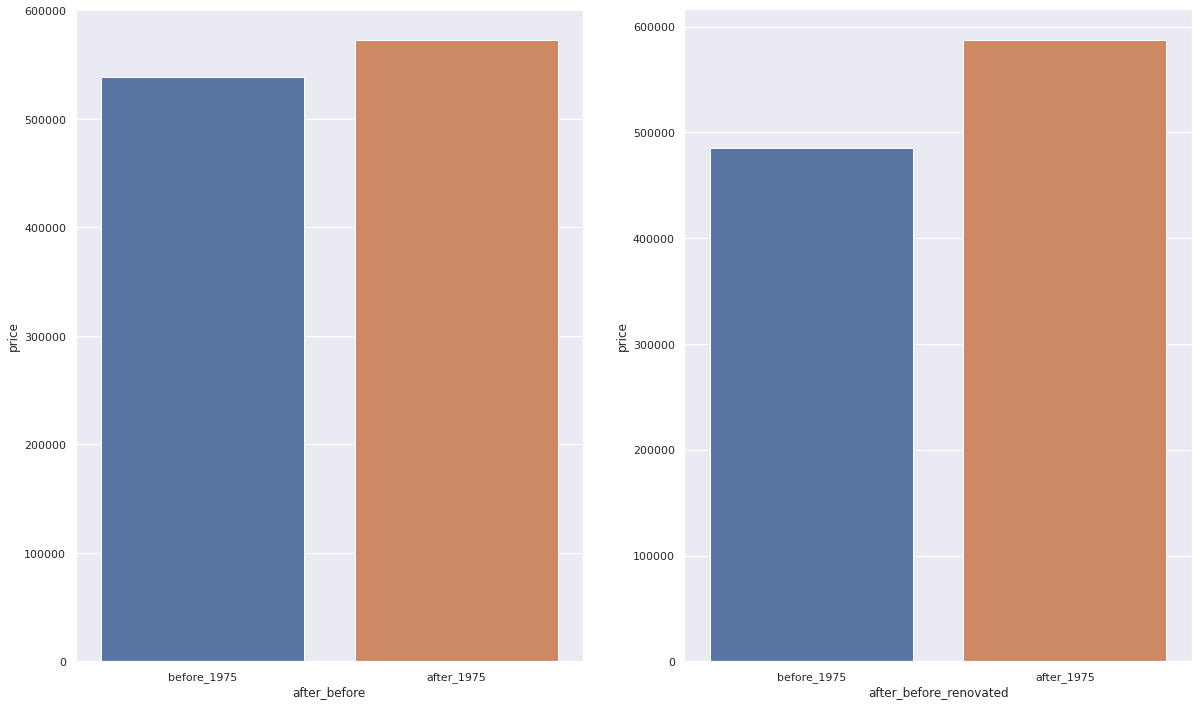

In [47]:
# yr_built
df = data[['yr_built', 'price']].groupby('yr_built').mean().reset_index()

df['after_before'] = df['yr_built'].apply(lambda x: 'before_1975' if x < 1975 else 'after_1975')


df2 = df[['after_before', 'price']].groupby('after_before').mean().reset_index()
plt.subplot(1, 2, 1)
sns.barplot(data=df2.sort_values('price'), x='after_before', y='price');


data['after_before_renovated'] = data[['yr_built', 'yr_renovated']].apply(lambda x: 'before_1975' if 
                                                                          ((x['yr_built'] < 1975) & (x['yr_renovated'] < 1975)) else 
                                                                          'after_1975', axis=1)

df = data[['after_before_renovated', 'price']].groupby('after_before_renovated').mean().reset_index()

plt.subplot(1, 2, 2)
sns.barplot(data=df.sort_values('price'), x='after_before_renovated', y='price');


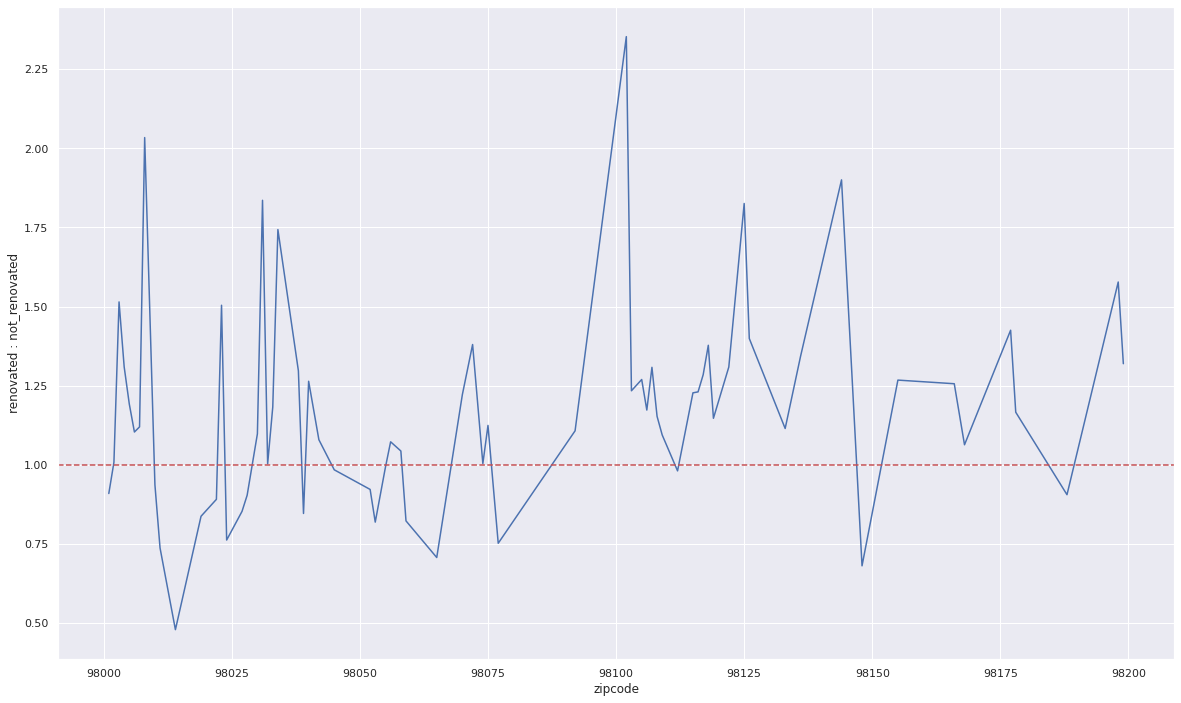

In [61]:
# imóveis que foram reformados por região
df1 = data[data['yr_renovated'] != 0][['zipcode', 'price']].groupby('zipcode').mean().reset_index() 
# imóveis que não foram reformados por região
df2 = data[data['yr_renovated'] == 0][['zipcode', 'price']].groupby('zipcode').mean().reset_index() 

df = df1.merge(df2, on='zipcode')
df.columns = ['zipcode', 'price_renovated', 'price_not_renovated']
              
df['renovated : not_renovated'] = df['price_renovated']/df['price_not_renovated']

graph = sns.lineplot(data=df, x='zipcode', y='renovated : not_renovated')
graph.axhline(1, color='r', linestyle='--')

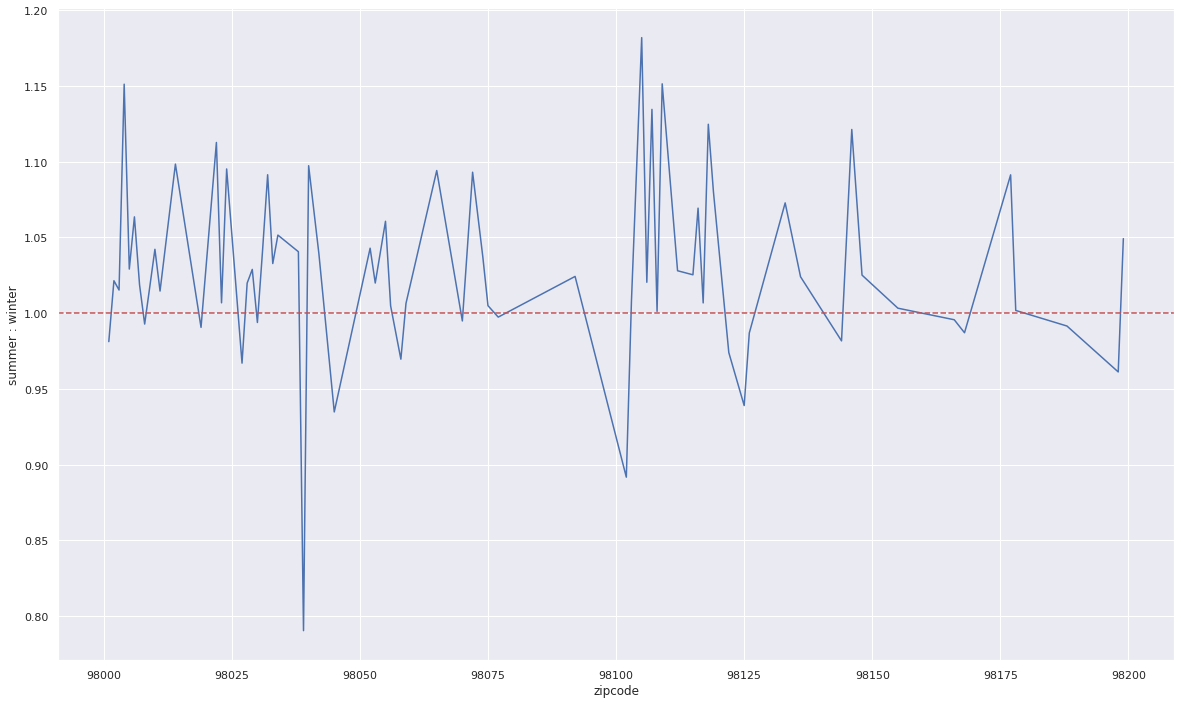

In [62]:
data['month'] = pd.to_datetime(data['date']).dt.month

data.loc[(data['month'] >= 6) & (data['month'] <= 8), 'temporal'] = 'Summer'
data.loc[(data['month'] >= 7) & (data['month'] <= 11), 'temporal'] = 'Autumn'
data.loc[(data['month'] == 12) | (data['month'] == 1) | (data['month'] == 2), 'temporal'] = 'Winter'
data.loc[(data['month'] >= 3) & (data['month'] <= 5), 'temporal'] = 'Spring'

price_summer = data.loc[(data['temporal'] == 'Summer'), 'price'].mean()    
price_winter = data.loc[(data['temporal'] == 'Winter'), 'price'].mean()

ratio1 = (price_summer/price_winter - 1)*100

df_summer = data[(data['temporal'] == 'Summer') | 
                 (data['temporal'] == 'Spring')][['zipcode', 'price']].groupby('zipcode').mean().reset_index()
df_winter = data[(data['temporal'] == 'Winter') | 
                 (data['temporal'] == 'Autumn')][['zipcode', 'price']].groupby('zipcode').mean().reset_index()

df = df_summer.merge(df_winter, on='zipcode')
df.columns = ['zipcode', 'mean_price_summer', 'mean_price_winter']
df['summer : winter'] = df['mean_price_summer']/df['mean_price_winter']

graph = sns.lineplot(data=df, x='zipcode', y='summer : winter')
graph.axhline(1, color='r', linestyle='--')